# How much money Lending Club has lost through loan defaultation?

In order to find out the answer, we look through the original data file and will estimate _loss_ for defaulted loans.

_loss_ is defined as the difference between the expected amount and total payment.
The expected amount is estimated by the loan term multiplied by monthly installment. The total payment as well as the date of last payment both are available. 



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

import pickle
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer

import datetime

import pickle

In [172]:
filepath = "C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\accepted_2007_to_2018Q4.csv"
df = pd.read_csv(filepath)

In [173]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
# Defining a new column 'new_status' and combine 'Charged Off' and 'Default' as well as any 'late' loans into one status

df['new_status'] = df['loan_status']
df.loc[df['loan_status']=='Late (31-120 days)', 'new_status'] = 'Default'
df.loc[df['loan_status']=='In Grace Period', 'new_status'] = 'Default'
df.loc[df['loan_status']=='Late (16-30 days)', 'new_status'] = 'Default'
df.loc[df['loan_status']=='Charged Off', 'new_status'] = 'Default'
df.loc[df['loan_status']=='Does not meet the credit policy. Status:Fully Paid', 'new_status'] = 'Fully Paid'
df.loc[df['loan_status']=='Does not meet the credit policy. Status:Charged Off', 'new_status'] = 'Default'


df.drop(columns='loan_status', inplace=True)

In [175]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,new_status
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Current
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Fully Paid


In [176]:
df =df[df['application_type'] == "Individual"]
print(df.shape)
df['application_type'].unique()

(2139958, 151)


array(['Individual'], dtype=object)

In [177]:
keeplist =['revol_util','dti', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'inq_last_6mths', 'earliest_cr_line', 
        'open_acc', 'mort_acc', 'annual_inc', 'issue_d', 'grade', 'sub_grade', 'funded_amnt', 'new_status', 'installment', 'int_rate', 
        'verification_status', 'term', 'revol_bal', 'fico_range_high', 'fico_range_low', 'id', 'emp_length', 'home_ownership',
        'num_rev_accts', 'pub_rec_bankruptcies', 'tax_liens', 'addr_state']

In [178]:
df = df[keeplist]

In [179]:
df.new_status.value_counts()

Fully Paid    1059283
Current        787191
Default        293484
Name: new_status, dtype: int64

In [180]:
df = df.dropna()


In [181]:
df.head()

,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,earliest_cr_line,open_acc,mort_acc,annual_inc,issue_d,...,revol_bal,fico_range_high,fico_range_low,id,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,addr_state
0,29.7,5.91,0.0,0.0,1.0,Aug-2003,7.0,1.0,55000.0,Dec-2015,...,2765.0,679.0,675.0,68407277,10+ years,MORTGAGE,9.0,0.0,0.0,PA
1,19.2,16.06,0.0,0.0,4.0,Dec-1999,22.0,4.0,65000.0,Dec-2015,...,21470.0,719.0,715.0,68355089,10+ years,MORTGAGE,27.0,0.0,0.0,SD
3,11.6,17.06,0.0,0.0,0.0,Sep-2008,13.0,1.0,110000.0,Dec-2015,...,7802.0,789.0,785.0,66310712,10+ years,MORTGAGE,13.0,0.0,0.0,NJ
4,64.5,25.37,0.0,0.0,3.0,Jun-1998,12.0,6.0,104433.0,Dec-2015,...,21929.0,699.0,695.0,68476807,3 years,MORTGAGE,19.0,0.0,0.0,PA
5,68.4,10.20,0.0,0.0,0.0,Oct-1987,5.0,0.0,34000.0,Dec-2015,...,8822.0,694.0,690.0,68426831,4 years,RENT,4.0,0.0,0.0,GA


In [182]:
df['Credit Length (year)'] = (pd.to_datetime(df['issue_d'])-pd.to_datetime(df['earliest_cr_line']))/np.timedelta64(1,'Y')


In [183]:
df = df.drop(columns = ['issue_d', 'addr_state', 'earliest_cr_line', 'grade'])
df = df.rename(columns={'new_status': 'Status'})

In [184]:
df.head()

,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,funded_amnt,...,revol_bal,fico_range_high,fico_range_low,id,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,Credit Length (year)
0,29.7,5.91,0.0,0.0,1.0,7.0,1.0,55000.0,C4,3600.0,...,2765.0,679.0,675.0,68407277,10+ years,MORTGAGE,9.0,0.0,0.0,12.334271
1,19.2,16.06,0.0,0.0,4.0,22.0,4.0,65000.0,C1,24700.0,...,21470.0,719.0,715.0,68355089,10+ years,MORTGAGE,27.0,0.0,0.0,16.000329
3,11.6,17.06,0.0,0.0,0.0,13.0,1.0,110000.0,C5,35000.0,...,7802.0,789.0,785.0,66310712,10+ years,MORTGAGE,13.0,0.0,0.0,7.247240
4,64.5,25.37,0.0,0.0,3.0,12.0,6.0,104433.0,F1,10400.0,...,21929.0,699.0,695.0,68476807,3 years,MORTGAGE,19.0,0.0,0.0,17.500702
5,68.4,10.20,0.0,0.0,0.0,5.0,0.0,34000.0,C3,11950.0,...,8822.0,694.0,690.0,68426831,4 years,RENT,4.0,0.0,0.0,28.167587


In [185]:
# Define a function to change the term from object type to numerical value, to be able to use it in loss calculation
def term_num(x):
    if x == ' 60 months':
        return 60
    else:
        return 36


In [186]:
df_test = df[df['Status']=='Current']

In [187]:
df_test.Status.value_counts()

Current    733287
Name: Status, dtype: int64

In [196]:
df_test = df_test.reset_index()

In [198]:
df_test.drop(columns='index', axis=1, inplace=True)

In [199]:
df_test.head()

,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,funded_amnt,...,revol_bal,fico_range_high,fico_range_low,id,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,Credit Length (year)
0,11.6,17.06,0.0,0.0,0.0,13.0,1.0,110000.0,C5,35000.0,...,7802.0,789.0,785.0,66310712,10+ years,MORTGAGE,13.0,0.0,0.0,7.247240
1,32.7,22.98,0.0,0.0,0.0,16.0,5.0,95000.0,C2,22400.0,...,13028.0,714.0,710.0,68356421,6 years,MORTGAGE,15.0,0.0,0.0,20.668460
2,56.3,26.40,0.0,0.0,0.0,13.0,2.0,70000.0,C2,16000.0,...,28705.0,724.0,720.0,68426545,1 year,MORTGAGE,21.0,0.0,0.0,27.830825
3,52.7,18.28,0.0,0.0,0.0,21.0,0.0,64000.0,B1,23000.0,...,24940.0,704.0,700.0,68506798,5 years,RENT,19.0,0.0,0.0,14.248068
4,24.1,34.29,0.0,0.0,0.0,11.0,4.0,118000.0,C2,16800.0,...,7849.0,684.0,680.0,68537655,10+ years,MORTGAGE,28.0,0.0,0.0,18.500038


In [200]:
df_train = df[df['Status']!='Current']

In [201]:
df_train['Term'] = df_train.term.apply(term_num)

In [202]:
df_train['int_earned'] = df_train['funded_amnt']*df_train['int_rate']/100*df_train['Term']/12

In [245]:
#estimating the current earning
current_earned = df_train.groupby('Status').int_earned.sum()['Fully Paid'] + df_train.groupby('Status').funded_amnt.sum()['Fully Paid'] - df_train.funded_amnt.sum()

#estimating total current investment
current_investment = df_train.funded_amnt.sum()

# Return on investment

ROI = current_earned/current_investment

print('Current ROI is: ', ROI)

Current ROI is:  0.13373889688206805


In [214]:
model = pickle.load(open("lr_model", "rb"))

In [219]:
# Preprocess the data to apply model.

X = df_test.drop(columns=['Status', 'id', 'verification_status'])


# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))



The new X has the columns added by One Hot Encoder, which has increased the number of columns from 22 to 69


In [221]:
df_train.home_ownership.value_counts()

MORTGAGE    596699
RENT        483874
OWN         125820
ANY            283
OTHER           42
NONE            41
Name: home_ownership, dtype: int64

In [222]:
df_test.home_ownership.value_counts()

MORTGAGE    346757
RENT        302976
OWN          82995
ANY            559
Name: home_ownership, dtype: int64

In [223]:
X['home_ownership_NONE'] = 0
X['home_ownership_OTHER'] = 0

In [225]:
y_pred = model.predict(X)

In [228]:
model_prediction = pd.DataFrame({'predicted_status': pd.Series(y_pred)})

In [234]:
df_test =df_test.join(model_prediction)
df_test.head()

,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,funded_amnt,...,fico_range_high,fico_range_low,id,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,Credit Length (year),predicted_status
0,11.6,17.06,0.0,0.0,0.0,13.0,1.0,110000.0,C5,35000.0,...,789.0,785.0,66310712,10+ years,MORTGAGE,13.0,0.0,0.0,7.247240,Fully Paid
1,32.7,22.98,0.0,0.0,0.0,16.0,5.0,95000.0,C2,22400.0,...,714.0,710.0,68356421,6 years,MORTGAGE,15.0,0.0,0.0,20.668460,Fully Paid
2,56.3,26.40,0.0,0.0,0.0,13.0,2.0,70000.0,C2,16000.0,...,724.0,720.0,68426545,1 year,MORTGAGE,21.0,0.0,0.0,27.830825,Fully Paid
3,52.7,18.28,0.0,0.0,0.0,21.0,0.0,64000.0,B1,23000.0,...,704.0,700.0,68506798,5 years,RENT,19.0,0.0,0.0,14.248068,Fully Paid
4,24.1,34.29,0.0,0.0,0.0,11.0,4.0,118000.0,C2,16800.0,...,684.0,680.0,68537655,10+ years,MORTGAGE,28.0,0.0,0.0,18.500038,Fully Paid


In [236]:
#estimating the current earning
df_test['Term'] = df_test.term.apply(term_num)
df_test['int_earned'] = df_test['funded_amnt']*df_test['int_rate']/100*df_test['Term']/12
earned = df_test.groupby('predicted_status').int_earned.sum()['Fully Paid'] + df_test.groupby('predicted_status').funded_amnt.sum()['Fully Paid'] - df_test.funded_amnt.sum()

#estimating total current investment
investment = df_test.funded_amnt.sum()

# Return on investment

ROI = earned/investment

print('Modeled ROI is: ', ROI)

Modeled ROI is:  0.5226139910848411


In [240]:
df_train = df_train.reset_index()
df_train.drop(columns='index', inplace=True)
df_train.head()

,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,funded_amnt,...,fico_range_low,id,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,Credit Length (year),Term,int_earned
0,29.7,5.91,0.0,0.0,1.0,7.0,1.0,55000.0,C4,3600.0,...,675.0,68407277,10+ years,MORTGAGE,9.0,0.0,0.0,12.334271,36,1510.92
1,19.2,16.06,0.0,0.0,4.0,22.0,4.0,65000.0,C1,24700.0,...,715.0,68355089,10+ years,MORTGAGE,27.0,0.0,0.0,16.000329,36,8884.59
2,64.5,25.37,0.0,0.0,3.0,12.0,6.0,104433.0,F1,10400.0,...,695.0,68476807,3 years,MORTGAGE,19.0,0.0,0.0,17.500702,60,11674.00
3,68.4,10.20,0.0,0.0,0.0,5.0,0.0,34000.0,C3,11950.0,...,690.0,68426831,4 years,RENT,4.0,0.0,0.0,28.167587,36,4818.24
4,84.5,14.67,0.0,0.0,0.0,12.0,4.0,180000.0,B2,20000.0,...,680.0,68476668,10+ years,MORTGAGE,16.0,0.0,0.0,25.500866,36,5502.00


In [241]:

XX = df_train.drop(columns=['Status', 'id', 'verification_status', 'Term', 'int_earned'])


# Choose the categorical columns
col_num =XX.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(XX)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(XX[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
XX.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
XX =XX.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

y_pred = model.predict(XX)
model_prediction = pd.DataFrame({'predicted_status': pd.Series(y_pred)})
df_train =df_train.join(model_prediction)
df_train.head()

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 22 to 71


,revol_util,dti,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,open_acc,mort_acc,annual_inc,sub_grade,funded_amnt,...,id,emp_length,home_ownership,num_rev_accts,pub_rec_bankruptcies,tax_liens,Credit Length (year),Term,int_earned,predicted_status
0,29.7,5.91,0.0,0.0,1.0,7.0,1.0,55000.0,C4,3600.0,...,68407277,10+ years,MORTGAGE,9.0,0.0,0.0,12.334271,36,1510.92,Fully Paid
1,19.2,16.06,0.0,0.0,4.0,22.0,4.0,65000.0,C1,24700.0,...,68355089,10+ years,MORTGAGE,27.0,0.0,0.0,16.000329,36,8884.59,Fully Paid
2,64.5,25.37,0.0,0.0,3.0,12.0,6.0,104433.0,F1,10400.0,...,68476807,3 years,MORTGAGE,19.0,0.0,0.0,17.500702,60,11674.00,Fully Paid
3,68.4,10.20,0.0,0.0,0.0,5.0,0.0,34000.0,C3,11950.0,...,68426831,4 years,RENT,4.0,0.0,0.0,28.167587,36,4818.24,Fully Paid
4,84.5,14.67,0.0,0.0,0.0,12.0,4.0,180000.0,B2,20000.0,...,68476668,10+ years,MORTGAGE,16.0,0.0,0.0,25.500866,36,5502.00,Fully Paid


In [244]:
earned = df_train.groupby('predicted_status').int_earned.sum()['Fully Paid'] 

#estimating total current investment
investment = df_train.groupby('predicted_status').funded_amnt.sum()['Fully Paid']

# Return on investment

ROI = earned/investment

print('Modeled ROI is: ', ROI)

Modeled ROI is:  0.5276208656664653


In [4]:
## Defining a dataframe that holds financial relevent data 
financial=df_train[['id', 'Status', 'loan_amnt', 'installment', 'int_rate', 'term', 'last_pymnt_d',\
                 'total_pymnt', 'total_rec_late_fee']]

In [14]:
financial.drop(df[df['new_status']=='Current'].index, inplace=True)

In [5]:
# Find the time(the number of month after the beginning of loan term) that a loan owner stops paying their loan

financial['pay_length'] = (pd.to_datetime(financial['last_pymnt_d'])- pd.to_datetime(financial['issue_d']))*12/np.timedelta64(1,'Y')
financial['pay_length'] =round(financial['pay_length'])


In [30]:
financial['Term'] = financial.term.apply(term_num)

In [31]:
financial['Term'].value_counts()

36    1043092
60     339292
Name: Term, dtype: int64

In [33]:
financial['expected'] = financial['Term']*financial['installment']

In [41]:
financial['expected_int'] =financial['int_rate']*financial['loan_amnt']/100 + financial['loan_amnt']

In [34]:
financial['funding_cost'] = financial['loan_amnt']*0.03

In [35]:
financial['investment'] = financial['loan_amnt'] + financial['funding_cost']

In [51]:
financial['int_earned'] = financial['loan_amnt']*financial['int_rate']/100*financial['Term']/12

In [52]:
financial.head()

,id,new_status,loan_amnt,issue_d,installment,int_rate,term,last_pymnt_d,total_pymnt,total_rec_late_fee,pay_length,Term,expected,funding_cost,investment,expected_int,int_earned
0,68407277,Fully Paid,3600.0,Dec-2015,123.03,13.99,36 months,Jan-2019,4421.723917,0.0,37.0,36,4429.08,108.0,3708.0,4103.64,1510.92
1,68355089,Fully Paid,24700.0,Dec-2015,820.28,11.99,36 months,Jun-2016,25679.660000,0.0,6.0,36,29530.08,741.0,25441.0,27661.53,8884.59
2,68341763,Fully Paid,20000.0,Dec-2015,432.66,10.78,60 months,Jun-2017,22705.924294,0.0,18.0,60,25959.60,600.0,20600.0,22156.00,10780.00
4,68476807,Fully Paid,10400.0,Dec-2015,289.91,22.45,60 months,Jul-2016,11740.500000,0.0,7.0,60,17394.60,312.0,10712.0,12734.80,11674.00
5,68426831,Fully Paid,11950.0,Dec-2015,405.18,13.44,36 months,May-2017,13708.948530,0.0,17.0,36,14586.48,358.5,12308.5,13556.08,4818.24


In [43]:
financial.groupby('new_status').loan_amnt.sum()

new_status
Default       4.776473e+09
Fully Paid    1.523680e+10
Name: loan_amnt, dtype: float64

array([[<AxesSubplot:title={'center':'term_per'}>,
        <AxesSubplot:title={'center':'loss'}>],
       [<AxesSubplot:title={'center':'pay_length'}>, <AxesSubplot:>]],
      dtype=object)

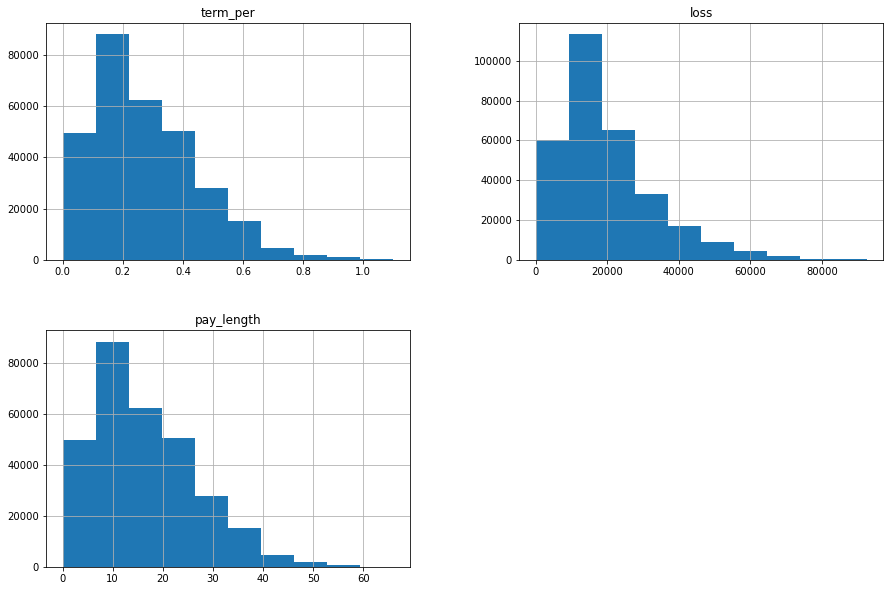

In [166]:
data[['term_per', 'loss', 'pay_length']].hist(figsize=(15,10))

# How much money would Lending Club save?

Load the data.

In [74]:
df = pd.read_csv("C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv")
df = df.drop(columns=['Unnamed: 0'])

Load the model

In [ ]:
## Define a pipeline and fit the model

In [61]:
y_pred = pipeXGbest.predict(X_res)

In [62]:
model_prediction = pd.concat({'loan_status': pd.Series(y_res), 'predicted_status': pd.Series(y_pred)}, axis=1)
model_prediction.index = id


In [63]:
results = model_prediction.merge(financial, how='left', left_on='id', right_on='id')

In [64]:
results.head()

,id,loan_status,predicted_status,new_status,loan_amnt,issue_d,installment,int_rate,term,last_pymnt_d,total_pymnt,total_rec_late_fee,pay_length,Term,expected,funding_cost,investment,expected_int,int_earned
0,66624733.0,Default,Default,Default,18000.0,Dec-2015,471.70,19.48,60 months,May-2017,9452.74,0.00,17.0,60.0,28302.00,540.00,18540.00,21506.4000,17532.0000
1,67849662.0,Default,Default,Default,4225.0,Dec-2015,146.16,14.85,36 months,Apr-2017,2558.87,0.00,16.0,36.0,5261.76,126.75,4351.75,4852.4125,1882.2375
2,67715283.0,Default,Fully Paid,Default,16000.0,Dec-2015,538.18,12.88,36 months,Nov-2018,17396.63,161.46,35.0,36.0,19374.48,480.00,16480.00,18060.8000,6182.4000
3,68341789.0,Default,Default,Default,24250.0,Dec-2015,701.01,24.24,60 months,Jul-2016,4124.42,0.00,7.0,60.0,42060.60,727.50,24977.50,30128.2000,29391.0000
4,68415473.0,Default,Default,Default,25000.0,Dec-2015,581.58,13.99,60 months,Feb-2018,14490.92,0.00,26.0,60.0,34894.80,750.00,25750.00,28497.5000,17487.5000


In [66]:
results.columns

Index(['id', 'loan_status', 'predicted_status', 'new_status', 'loan_amnt',
       'issue_d', 'installment', 'int_rate', 'term', 'last_pymnt_d',
       'total_pymnt', 'total_rec_late_fee', 'pay_length', 'Term', 'expected',
       'funding_cost', 'investment', 'expected_int', 'int_earned'],
      dtype='object')

In [67]:
#estimating the current earning
earned = results.groupby('predicted_status').int_earned.sum()['Fully Paid'] + results.groupby('predicted_status').loan_amnt.sum()['Fully Paid'] - results.loan_amnt.sum()

#estimating total current investment
investment = results.loan_amnt.sum()

# Return on investment

ROI = earned/investment

print('modeled ROI is: ', ROI)

modeled ROI is:  -0.4356337493346323


In [129]:
results_saving = results.loc[(results['loan_status']=='Default') & (results['predicted_status']=='Default'), :]

In [170]:
results_saving.head()

,loan_status,predicted_status,id,loan_amnt,installment,int_rate,total_pymnt,total_rec_late_fee,pay_length,Term,expected,loss
0,Default,Default,66624733.0,18000.0,471.70,19.48,9452.74,0.00,17.0,60.0,28302.0,18849.26
1,Default,Default,67849662.0,4225.0,146.16,14.85,2558.87,0.00,16.0,60.0,8769.6,6210.73
2,Default,Default,67715283.0,16000.0,538.18,12.88,17396.63,161.46,35.0,60.0,32290.8,14894.17
3,Default,Default,68341789.0,24250.0,701.01,24.24,4124.42,0.00,7.0,60.0,42060.6,37936.18
4,Default,Default,68415473.0,25000.0,581.58,13.99,14490.92,0.00,26.0,60.0,34894.8,20403.88


In [171]:
print('Total amount Lending Club has lost is {}.'.format(data.loss.sum()))

Total amount Lending Club has lost is 5998214435.158355.


In [173]:
print('Lending Club would have saved ${} ({}% of the total loss), if they had used our model'.format(round(results_saving.loss.sum(),2),round(100*results_saving.loss.sum()/data.loss.sum(),2)))

Lending Club would have saved $3764828296.1 (62.77% of the total loss), if they had used our model
